In [2]:
# ------------------------------------------
# 1) IMPORT LIBRARIES
# ------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)


In [3]:
# ------------------------------------------
# 2) PROBLEM STATEMENT
# ------------------------------------------
print("Business Goal: Predict which customers are likely to churn (leave).")
print("Why: Retaining customers is cheaper than acquiring new ones.")
print("Success Metric: Accuracy, Precision, Recall, F1, ROC-AUC")
print("Special Focus: Recall on churners (catching more at-risk customers).")


Business Goal: Predict which customers are likely to churn (leave).
Why: Retaining customers is cheaper than acquiring new ones.
Success Metric: Accuracy, Precision, Recall, F1, ROC-AUC
Special Focus: Recall on churners (catching more at-risk customers).


In [4]:
# ------------------------------------------
# 3) CREATE SYNTHETIC DATASET
# ------------------------------------------
np.random.seed(7)
n = 1000

tenure = np.random.randint(1, 60, n)                  # months with company
monthly = np.random.randint(200, 2000, n)             # monthly bill (INR)
premium = np.random.choice([0, 1], size=n, p=[0.6,0.4]) # premium plan
support_tix = np.random.poisson(lam=1.5, size=n)      # support tickets

# Churn logic (synthetic)
base_risk = 0.12
risk = (
    base_risk
    + 0.25 * (tenure < 6)
    + 0.18 * ((monthly > 1500) & (premium == 0))
    + 0.12 * (support_tix > 3)
)
risk = np.clip(risk, 0, 0.95)
churn = (np.random.rand(n) < risk).astype(int)

df = pd.DataFrame({
    "CustomerID": np.arange(1, n+1),
    "Tenure": tenure,
    "MonthlyCharges": monthly,
    "Premium": premium,
    "SupportTickets": support_tix,
    "Churn": churn
})

df.head(10)


,CustomerID,Tenure,MonthlyCharges,Premium,SupportTickets,Churn
0,1,48,1938,0,2,0
1,2,5,1207,0,3,1
2,3,26,1213,0,2,0
3,4,55,1715,0,2,0
4,5,4,801,0,2,0
5,6,20,800,0,3,0
6,7,24,1768,0,3,0
7,8,40,751,0,2,0
8,9,29,1912,0,1,1
9,10,58,1174,0,0,0


In [5]:
# ------------------------------------------
# 4) DATA UNDERSTANDING
# ------------------------------------------
print("Shape:", df.shape)
print("\nMissing values:\n", df.isna().sum())
print("\nChurn distribution:\n", df["Churn"].value_counts(normalize=True))
df.describe()


Shape: (1000, 6)

Missing values:
 CustomerID        0
Tenure            0
MonthlyCharges    0
Premium           0
SupportTickets    0
Churn             0
dtype: int64

Churn distribution:
 Churn
0    0.835
1    0.165
Name: proportion, dtype: float64


,CustomerID,Tenure,MonthlyCharges,Premium,SupportTickets,Churn
count,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000
mean,500.500000,30.202000,1113.34500,0.40600,1.540000,0.165000
std,288.819436,17.244088,519.21697,0.49133,1.260154,0.371366
min,1.000000,1.000000,201.00000,0.00000,0.000000,0.000000
25%,250.750000,15.000000,679.50000,0.00000,1.000000,0.000000
50%,500.500000,30.000000,1117.50000,0.00000,1.000000,0.000000
75%,750.250000,45.000000,1558.25000,1.00000,2.000000,0.000000
max,1000.000000,59.000000,1997.00000,1.00000,8.000000,1.000000


/tmp/ipython-input-3474033506.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("Churn by tenure bucket:\n", df.groupby(tenure_binned)["Churn"].mean())


Churn by tenure bucket:
 Tenure
1-6      0.315315
7-12     0.127660
13-24    0.134615
25-36    0.155914
37-60    0.152120
Name: Churn, dtype: float64


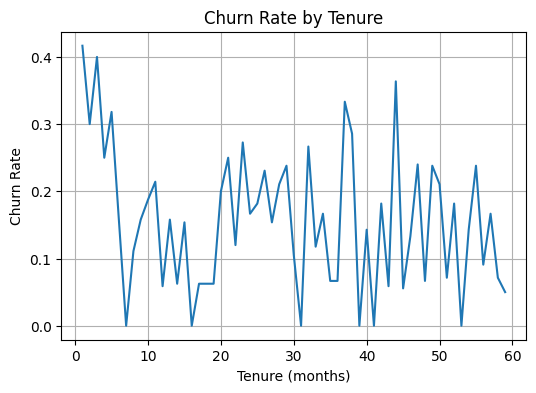


Churn by monthly charge bucket:
 MonthlyCharges
200-800      0.109718
801-1200     0.151111
1201-1600    0.180617
1601-2000    0.240175
Name: Churn, dtype: float64


/tmp/ipython-input-3474033506.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("\nChurn by monthly charge bucket:\n", df.groupby(monthly_binned)["Churn"].mean())


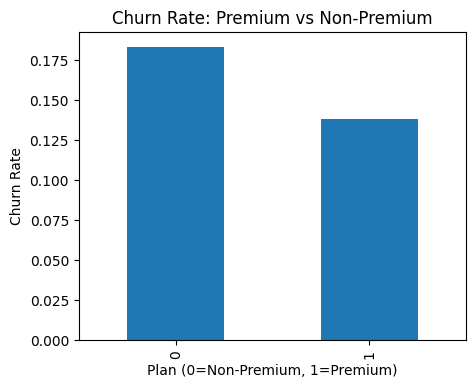

In [6]:
# ------------------------------------------
# 5) EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------------------------

# Churn rate by tenure buckets
tenure_bins = [0,6,12,24,36,60]
tenure_labels = ["1-6","7-12","13-24","25-36","37-60"]
tenure_binned = pd.cut(df["Tenure"], bins=tenure_bins, labels=tenure_labels)
print("Churn by tenure bucket:\n", df.groupby(tenure_binned)["Churn"].mean())

# Plot churn rate by tenure (line)
df.groupby("Tenure")["Churn"].mean().plot(kind="line", figsize=(6,4))
plt.title("Churn Rate by Tenure")
plt.xlabel("Tenure (months)")
plt.ylabel("Churn Rate")
plt.grid(True)
plt.show()

# Churn by monthly charge bins
monthly_bins = [199,800,1200,1600,2000]
monthly_labels = ["200-800","801-1200","1201-1600","1601-2000"]
monthly_binned = pd.cut(df["MonthlyCharges"], bins=monthly_bins, labels=monthly_labels)
print("\nChurn by monthly charge bucket:\n", df.groupby(monthly_binned)["Churn"].mean())

# Plot churn rate by plan type
df.groupby("Premium")["Churn"].mean().plot(kind="bar", figsize=(5,4))
plt.title("Churn Rate: Premium vs Non-Premium")
plt.xlabel("Plan (0=Non-Premium, 1=Premium)")
plt.ylabel("Churn Rate")
plt.show()


In [7]:
# ------------------------------------------
# 6) BASELINE MODEL (DummyClassifier)
# ------------------------------------------
X = df[["Tenure","MonthlyCharges","Premium","SupportTickets"]]
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_test)

print("Baseline Metrics:")
print("Accuracy:", accuracy_score(y_test, base_pred))
print("Precision:", precision_score(y_test, base_pred, zero_division=0))
print("Recall:", recall_score(y_test, base_pred, zero_division=0))
print("F1:", f1_score(y_test, base_pred, zero_division=0))


Baseline Metrics:
Accuracy: 0.835
Precision: 0.0
Recall: 0.0
F1: 0.0


Logistic Regression Metrics (default threshold=0.5):
Accuracy: 0.835
Precision: 0.0
Recall: 0.0
F1: 0.0
ROC AUC: 0.6111413536563238

Confusion Matrix:
 [[167   0]
 [ 33   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


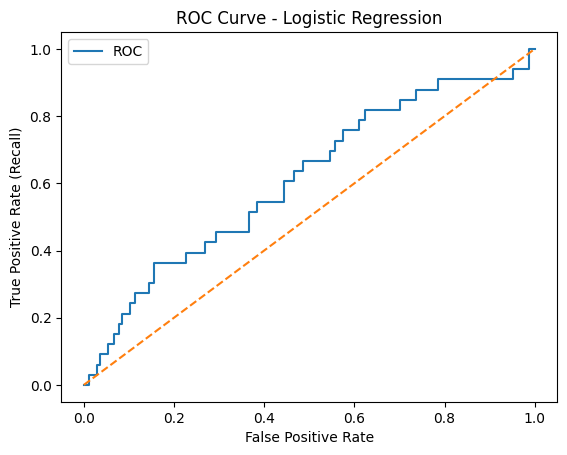

In [8]:
# ------------------------------------------
# 7) LOGISTIC REGRESSION MODEL
# ------------------------------------------
logit = LogisticRegression(max_iter=200)
logit.fit(X_train, y_train)

pred = logit.predict(X_test)
proba = logit.predict_proba(X_test)[:,1]

print("Logistic Regression Metrics (default threshold=0.5):")
print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1:", f1_score(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, proba))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))

# Plot ROC Curve
fpr, tpr, thr = roc_curve(y_test, proba)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


In [9]:
# ------------------------------------------
# 8) THRESHOLD TUNING (to improve recall)
# ------------------------------------------
def metrics_at_threshold(y_true, probas, t=0.5):
    pred_t = (probas >= t).astype(int)
    return {
        "Threshold": t,
        "Accuracy": accuracy_score(y_true, pred_t),
        "Precision": precision_score(y_true, pred_t, zero_division=0),
        "Recall": recall_score(y_true, pred_t, zero_division=0),
        "F1": f1_score(y_true, pred_t, zero_division=0),
        "ConfusionMatrix": confusion_matrix(y_true, pred_t).tolist()
    }

for t in [0.5, 0.4, 0.3]:
    print(metrics_at_threshold(y_test, proba, t))


{'Threshold': 0.5, 'Accuracy': 0.835, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'ConfusionMatrix': [[167, 0], [33, 0]]}
{'Threshold': 0.4, 'Accuracy': 0.835, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'ConfusionMatrix': [[167, 0], [33, 0]]}
{'Threshold': 0.3, 'Accuracy': 0.825, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'ConfusionMatrix': [[165, 2], [33, 0]]}


In [10]:
# ------------------------------------------
# 9) FEATURE IMPORTANCE (Logistic Coefficients)
# ------------------------------------------
coeffs = pd.Series(logit.coef_[0], index=X.columns).sort_values(key=lambda x: abs(x), ascending=False)
print("Feature Importance (Logistic Coefficients):")
print(coeffs)


Feature Importance (Logistic Coefficients):
SupportTickets    0.179807
Premium          -0.137633
Tenure           -0.013685
MonthlyCharges    0.000552
dtype: float64


In [11]:
# ------------------------------------------
# 10) NEXT STEPS (print only)
# ------------------------------------------
print("Next Steps:")
print("- Engineer more features (contract type, payment method, region).")
print("- Try tree-based models (RandomForest, XGBoost) for better recall.")
print("- Use cross-validation for robust evaluation.")
print("- Tune probability threshold based on business budget for retention.")
print("- Deploy model & monitor for drift.")


Next Steps:
- Engineer more features (contract type, payment method, region).
- Try tree-based models (RandomForest, XGBoost) for better recall.
- Use cross-validation for robust evaluation.
- Tune probability threshold based on business budget for retention.
- Deploy model & monitor for drift.
